<a href="https://colab.research.google.com/github/ShohamWeiss/Machine-Vision-Project/blob/master/Project%20Research/Trial_1_Rotating_Image_of_Hand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparing the data

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.5MB 4.6MB/s 


In [2]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import copy
import random
from tensorflow_examples.models.pix2pix import pix2pix

## Checking GPU

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Creating a background and hand

In [4]:
def get_image(file, resize = False):
  img = PIL.Image.open(file)
  if (resize):
    img.thumbnail(resize)
  arr = np.array(img) / 255
  if (arr.shape[2] == 4):
    arr = arr[:,:,0:3]
  return arr

In [5]:
def addHand(newX,newY,img,hand):
  newImg = copy.deepcopy(img)
  for x in range(hand.shape[1]-1):
    for y in range(hand.shape[0]-1):
      if (hand[y,x,0] < 0.92):
        newImg[y+newY,x+newX] = hand[y,x]
  return newImg

In [6]:
def getHand(num):
  hand = get_image('hand'+str(num)+'.jpg', resize=(800*(1/10),600*(1/10)))
  dic = {'1' : {'tip' : np.array([13,23]), 'base' : np.array([40,18])},
         '2' : {'tip' : np.array([20,17]), 'base' : np.array([35,23])},
         '3' : {'tip' : np.array([25,12]), 'base' : np.array([32,27])},
         '4' : {'tip' : np.array([37,17]), 'base' : np.array([33,33])},
         '5' : {'tip' : np.array([46,25]), 'base' : np.array([35,37])},
         '6' : {'tip' : np.array([53,41]), 'base' : np.array([31,38])}}
  return hand, dic[str(num)]

In [7]:
def addDot(x,y,img, rad = 3):
  for delx in np.arange(-rad,rad):
    for dely in np.arange(-rad,rad):
      img[y+dely,x+delx] = 1
  return img

In [8]:
bknds = []
files = ['manNoHandsSquare1.png', 'office_square.jpg', 'manyPeopleSquare.jpg', 'manyPeopleSquare2.jpg', 'womanSquare.jpg']
for file in files:
  bknd = get_image(file, resize=(128,128))
  bknds.append(bknd)

(128, 128, 3)
(60, 70, 3)


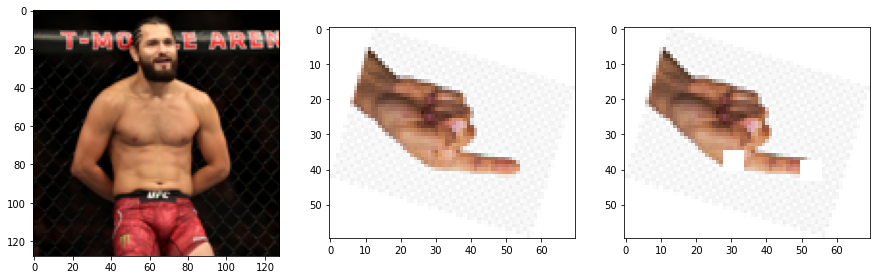

In [9]:
bknd = get_image('office_square.jpg', resize=(128,128))
print(bknd.shape)
hand, dots = getHand(6)
print(hand.shape)
handWithDots = addDot(dots['tip'][0], dots['tip'][1], copy.deepcopy(hand))
handWithDots = addDot(dots['base'][0], dots['base'][1], handWithDots)

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(1, 3, 1)
plt.imshow(bknds[0])
ax = plt.subplot(1, 3, 2)
plt.imshow(hand)
ax = plt.subplot(1, 3, 3)
plt.imshow(handWithDots)

### Creating images with random hand orientations

In [10]:
images = []
labels = []
DATA_SIZE = 1000
for i in range(DATA_SIZE):
  flip = random.randint(0,1)
  num = random.randint(1,4)
  bkndNum = random.randint(0,len(bknds)-1)
  bknd = bknds[bkndNum]
  # num = 3
  hand, info = getHand(num)
  x = random.randint(0,bknd.shape[1]-hand.shape[1])
  y = random.randint(0,bknd.shape[0]-hand.shape[0])

  img = addHand(x,y,bknd, hand)
  mask = np.zeros((128,128,1))
  mask = addDot(info['tip'][0]+x,info['tip'][1]+y,mask)
  mask = addDot(info['base'][0]+x,info['base'][1]+y,mask)
  if (flip == 1):
    mask = mask[::-1]
    img = img[::-1]
  images.append(img)
  # labels.append([info['tip'][0]+x,info['tip'][1]+y,info['base'][0]+x,info['base'][1]+y])
  labels.append(mask)
  # plt.imshow(img)
print(len(images), labels[0].shape)

1000 (128, 128, 1)


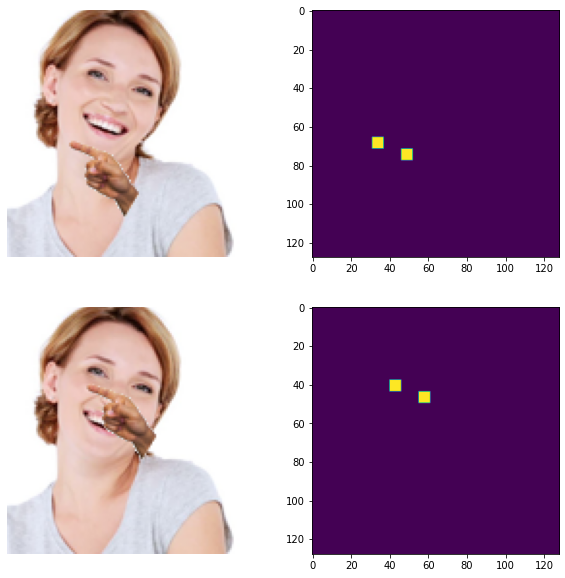

In [11]:
plt.figure(figsize=(10, 10)) 
for i in [1,3]:
  ax = plt.subplot(2, 2, i)
  plt.axis("off")
  plt.imshow(images[i])
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(np.reshape(labels[i], (128,128)))

### Creating training/testing data


In [12]:
TRAIN_SIZE = int(round(DATA_SIZE*0.8,1))
training_images = np.array(images[:TRAIN_SIZE])
training_labels = np.array(labels[:TRAIN_SIZE])
testing_images = np.array(images[TRAIN_SIZE:])
testing_labels = np.array(labels[TRAIN_SIZE:])

print(training_images.shape)

(800, 128, 128, 3)


## Building a unet model

In [42]:
OUTPUT_CHANNELS = 1

In [43]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

# Use the activation of these layers
layer_names = [
      'block_1_expand_relu', # 64x64
      'block_3_expand_relu', # 32x32
      'block_6_expand_relu', # 16x16
      'block_13_expand_relu', # 8x8
      'block_16_expand_relu', # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [44]:
up_stack = [
    pix2pix.upsample(512, 3), # 4x4 -> 8x8
    pix2pix.upsample(256, 3), # 8x8 -> 16x16
    pix2pix.upsample(128, 3), # 16x16 -> 32x32
    pix2pix.upsample(64, 3), # 32x32 -> 64x64
]

In [45]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
  
  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same') #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [46]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [48]:
training_labels.shape

(800, 128, 128, 1)

In [63]:
model.fit(training_images,training_labels, epochs=20, validation_split=0.1)

Epoch 1/20
23/23 [==============================] - 2s 69ms/step - loss: 7.4107e-04 - accuracy: 0.9998 - val_loss: 0.0197 - val_accuracy: 0.9962
Epoch 2/20
23/23 [==============================] - 1s 65ms/step - loss: 7.0676e-04 - accuracy: 0.9998 - val_loss: 0.0193 - val_accuracy: 0.9963
Epoch 3/20
23/23 [==============================] - 2s 65ms/step - loss: 6.0763e-04 - accuracy: 0.9998 - val_loss: 0.0193 - val_accuracy: 0.9962
Epoch 4/20
23/23 [==============================] - 1s 65ms/step - loss: 5.5341e-04 - accuracy: 0.9999 - val_loss: 0.0200 - val_accuracy: 0.9962
Epoch 5/20
23/23 [==============================] - 1s 65ms/step - loss: 4.7003e-04 - accuracy: 0.9999 - val_loss: 0.0197 - val_accuracy: 0.9962
Epoch 6/20
23/23 [==============================] - 1s 65ms/step - loss: 4.2674e-04 - accuracy: 0.9999 - val_loss: 0.0205 - val_accuracy: 0.9962
Epoch 7/20
23/23 [==============================] - 1s 65ms/step - loss: 3.7687e-04 - accuracy: 0.9999 - val_loss: 0.0211 - val_ac

In [64]:
model.evaluate(testing_images,testing_labels)

7/7 [==============================] - 0s 25ms/step - loss: 0.0226 - accuracy: 0.9962


[0.022646160796284676, 0.9962329268455505]

In [65]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [66]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [67]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [68]:
preds = model.predict(testing_images)

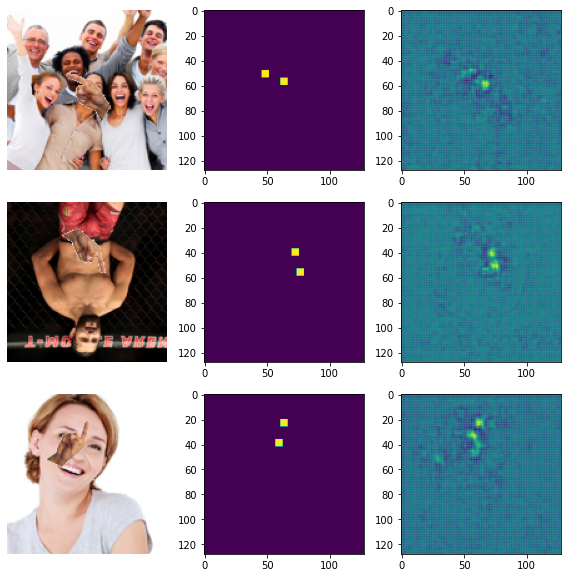

In [69]:
fig = plt.figure(figsize=(10,10))
for i in [1,4,7]:
  ax = plt.subplot(3, 3, i)
  plt.axis("off")
  plt.imshow(testing_images[i])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.reshape(testing_labels[i],(128,128)))
  ax = plt.subplot(3, 3, i + 2)
  plt.imshow(np.reshape(preds[i],(128,128)))

Trying real image

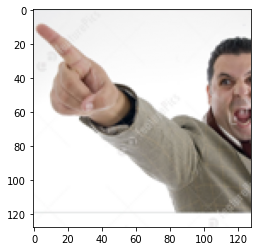

In [70]:
bknd2 = get_image('man-pointingSquare.jpg', (128,128,3))
bknd2.shape
plt.imshow(bknd2)

In [71]:
data = np.array([bknd2])
print(data.shape)
predictions = model.predict(data)

(1, 128, 128, 3)


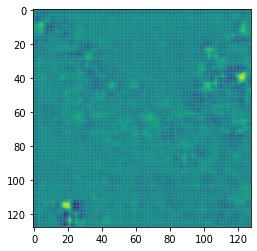

In [72]:
plt.imshow(np.reshape(predictions[0],(128,128)))

## Building Custom model


In [73]:
model = tf.keras.Sequential([
            tf.keras.layers.ZeroPadding2D(),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64, (3,3)),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(128, (3,3)),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64),
            tf.keras.layers.Dense(4)
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [32]:
model.fit(training_images, training_labels, epochs=10, validation_split=0.1, batch_size=10)

Epoch 1/10


ValueError: ignored

In [ ]:
base_model2.fit(training_images, training_labels, epochs=10, validation_split=0.1, batch_size=10)

In [ ]:
model.evaluate(testing_images,testing_labels)